<a href="https://colab.research.google.com/github/mukulpalmia07/Twitter_Sentiment_Analysis/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle # Installing Kaggle Library

In [2]:
# Configuring the path of kaggle.json file
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#Importing Twitter Sentiment Dataset

In [3]:
# API to fetch the dataset from kaggle
! kaggle datasets download -d kazanova/sentiment140

 87% 70.0M/80.9M [00:00<00:00, 128MB/s]
100% 80.9M/80.9M [00:00<00:00, 129MB/s]


In [5]:
# Extracting the compressed dataset

from zipfile import ZipFile
dataset = '/content/sentiment140.zip'
with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("The dataset has been extracted!")

The dataset has been extracted!


#Importing the Dependencies

In [69]:
import numpy as np
import pandas as pd
import re # Regular Expression
from nltk.corpus import stopwords # Natural Language Tool Kit
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
# Printing the stopwords in English
print(stopwords.words('english')) # Machine Learning Model doesn't require these word and also not required for processing

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

#Data Processing

In [11]:
# Loading the data from csv file to pandas dataframe
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1')

In [12]:
# Checking the Number of rows and columns
twitter_data.shape

(1599999, 6)

In [13]:
# Printing the first 10 rows of the dataframe
twitter_data.head(10)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing


In [17]:
# Naming the columns and reading the dataset again
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', names = column_names, encoding = 'ISO-8859-1')

In [18]:
# Checking the Number of rows and columns
twitter_data.shape

(1600000, 6)

In [20]:
# Counting the number of missing values in the dataset
twitter_data.isnull().sum() # Tells how many missing values are there in each columns

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [22]:
# Checking the distribution of target column
twitter_data['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

CONVERT THE TARGET '4' TO '1'

In [25]:
twitter_data.replace({'target': {4:1}}, inplace = True)

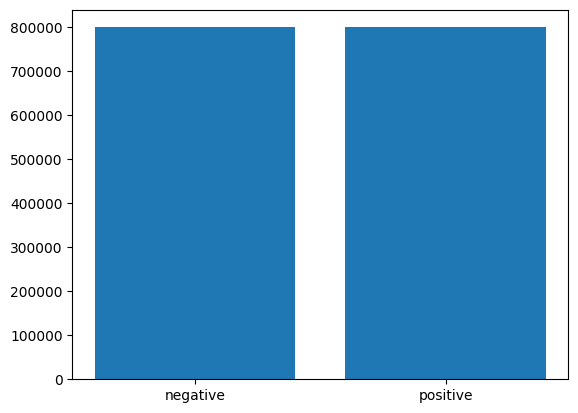

In [68]:
# Checking the distribution of target column
plt.bar(['negative', 'positive'],twitter_data['target'].value_counts())
plt.show()

0 ---> Negative Tweet

1 ---> Positive Tweet

STEMMING

Process of reducing a word to its root word

In [27]:
port_stem = PorterStemmer()

In [28]:
def stemming(content):

  stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)

  return stemmed_content

In [29]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

In [32]:
twitter_data.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [31]:
# Separating the data and label
X = twitter_data['stemmed_content'].values
Y = twitter_data['target'].values

#Splitnig the data into training and test data

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 2)

In [34]:
print(X.shape, X_train.shape, X_test.shape)

(1600000,) (1280000,) (320000,)


In [35]:
# Converting the textual data to numerical data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Training the Machine Learning Model

Logistic Regression

In [38]:
model = LogisticRegression(max_iter = 1000)

In [39]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

# Model Evaluation

Accuracy Score

In [40]:
# Accuracy score on the Training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)

In [41]:
print('Accuracy score on the training data :', training_data_accuracy)

Accuracy score on the training data : 0.81018984375


In [87]:
# Accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)

In [88]:
print('Accuracy score on the testing data :', test_data_accuracy)

Accuracy score on the testing data : 0.7780375


Model Accuracy = 77.8 %

Confusion Matrix

In [89]:
Y_pred = model.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred, labels = twitter_data['target'].unique())
twitter_data_cm = pd.DataFrame(cm, index = twitter_data['target'].unique(), columns = twitter_data.target.unique())
twitter_data_cm

,0,1
0,121445,38555
1,32473,127527


Confusion Matrix in percentage expression

In [90]:
twitter_data_cm_percentage = twitter_data_cm.copy()
for val in twitter_data_cm_percentage:
  twitter_data_cm_percentage[val] /= twitter_data_cm_percentage[val].sum()
twitter_data_cm_percentage

,0,1
0,0.789024,0.232144
1,0.210976,0.767856


# Saving the trained model

In [44]:
import pickle

In [45]:
filename = 'trained_model.sav'
pickle.dump(model, open(filename, 'wb'))

#Using the saved model for the future predictions

In [46]:
# Loading the saved model
loaded_model = pickle.load(open('/content/trained_model.sav', 'rb'))

In [80]:
new_tweets = 'hey, congrats mr mukul for finally joining twitter'
vectTweet = vectorizer.transform(np.array([new_tweets]))
prediction = loaded_model.predict(vectTweet)
print(prediction[0])
if prediction[0] > 0:
  print('Tweet is Positive')
elif prediction[0] == 0:
  print('Tweet is Negative')
else:
  print('Tweet is Neutral')

1
Tweet is Positive


In [85]:
tweetList = ['Best Game Ever!', 'Working days are worst....']
vectTweet = vectorizer.transform(np.array(tweetList))
prediction = loaded_model.predict(vectTweet)
for val, i in enumerate(tweetList):
  print(i, ': This tweet is', 'positive' if prediction[val] == 1 else 'negative')

Best Game Ever! : This tweet is positive
Working days are worst.... : This tweet is negative
